# Scenario 2 — Modular experiment notebook

This notebook runs scenario 2 training pipeline. It uses the modular codebase: `src.config`, `src.data`, and `src.train`.
Use the CLI runner `run_experiment.py` for reproducible command-line runs; this notebook is mainly for quick debugging and visualization.

In [5]:
# Imports
import torch
import matplotlib.pyplot as plt
from pathlib import Path

from src.config import load_config, set_seed
from src.data import get_dataloaders
from src.train import Trainer
from src.models import Regressor, FeatureExtractor, ActivityClassifier

# Notebook-friendly plotting
%matplotlib inline

In [16]:
# Load merged config (base + experiment) and optionally override small values here
base_cfg = "../configs/base.yaml"  # Fixed path relative to notebooks/
exp_cfg = "../configs/scenario2.yaml"  # Fixed path relative to notebooks/
opts = []  # e.g. [alpha=1.0]

cfg = load_config(base_cfg, exp_cfg, opts=opts)
set_seed(getattr(cfg, 'seed', None))
print('device:', cfg.device)
print('Loaded config from', exp_cfg)
print('dataset_name:', getattr(cfg, 'dataset_name', 'NOT_FOUND'))
print('mmfit_data_dir:', getattr(cfg, 'mmfit_data_dir', 'NOT_FOUND'))

device: mps
Loaded config from ../configs/scenario2.yaml
dataset_name: mmfit
mmfit_data_dir: ../datasets/mm-fit/


In [14]:
# Save merged config next to outputs for reproducibility (optional)
import json, time
import torch
import numpy as np

def _ns_to_dict(ns):
    if isinstance(ns, dict):
        return ns
    d = {}
    for k, v in vars(ns).items():
        if hasattr(v, '__dict__') and not isinstance(v, torch.dtype):
            d[k] = _ns_to_dict(v)
        elif isinstance(v, (torch.dtype, torch.device)):
            d[k] = str(v)  # Convert torch objects to string
        elif isinstance(v, np.dtype):
            d[k] = str(v)  # Convert numpy dtype to string
        elif callable(v):
            d[k] = f"<callable: {v.__name__}>"
        else:
            try:
                # Test if JSON serializable
                json.dumps(v)
                d[k] = v
            except (TypeError, ValueError):
                d[k] = str(v)
    return d

ts = time.strftime('%Y%m%d-%H%M%S')
out_dir = Path('../outputs') / 'scenario2' / ts
out_dir.mkdir(parents=True, exist_ok=True)
cfg_dict = _ns_to_dict(cfg)
(out_dir / 'config_merged.json').write_text(json.dumps(cfg_dict, indent=2))
print('Saved merged config to', out_dir)

Saved merged config to ../outputs/scenario2/20250906-134624


In [17]:
# Create dataloaders from factory
dls = get_dataloaders(cfg.dataset_name, cfg)  # expected keys: 'train','val','test'
print('Datasets sizes:', {k: len(v.dataset) for k, v in dls.items()})

Datasets sizes: {'train': 8400, 'val': 2800, 'test': 2800}


In [18]:
# Build models from utils.modules (constructors should accept cfg args)
device = getattr(cfg, 'torch_device', torch.device(cfg.device))

models = {
    'pose2imu': Regressor(
        in_ch=cfg.in_ch,
        num_joints=cfg.num_joints,
        window_length=cfg.sensor_window_length,
    ).to(device),
    'fe': FeatureExtractor().to(device),
    'ac': ActivityClassifier(f_in=cfg.ac_fin, n_classes=cfg.ac_num_classes).to(device),
}

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print('param counts:', {k: count_params(m) for k, m in models.items()})

param counts: {'pose2imu': 4408836, 'fe': 68626, 'ac': 1111}


In [ ]:
# Optimizer, scheduler and Trainer
# Convert lr to float if it's a string (YAML sometimes loads 1e-3 as string)
lr = float(cfg.lr) if isinstance(cfg.lr, str) else cfg.lr

params = sum([list(m.parameters()) for m in models.values()], [])
optimizer = torch.optim.Adam(params, lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=cfg.patience)

trainer = Trainer(models=models, dataloaders=dls, optimizer=optimizer, scheduler=scheduler, cfg=cfg, device=device)
print('Trainer instantiated')

lr value: 1e-3, type: <class 'str'>
Trainer instantiated
Trainer instantiated


In [ ]:
# Run training (for quick notebook tests, override epochs in cfg or pass a small number)
# For testing, you can use: history = trainer.fit(1) 
# For full training, use: history = trainer.fit(cfg.epochs)
epochs_to_run = 1  # Change this to cfg.epochs for full training
history = trainer.fit(epochs_to_run)
print('Training finished. History keys:', list(history.keys()))

Original epochs: 100


/Users/parham/miniconda3/envs/har/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/parham/miniconda3/envs/har/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/parham/miniconda3/envs/har/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training finished. History keys: ['train_loss', 'val_loss', 'train_f1', 'val_f1']


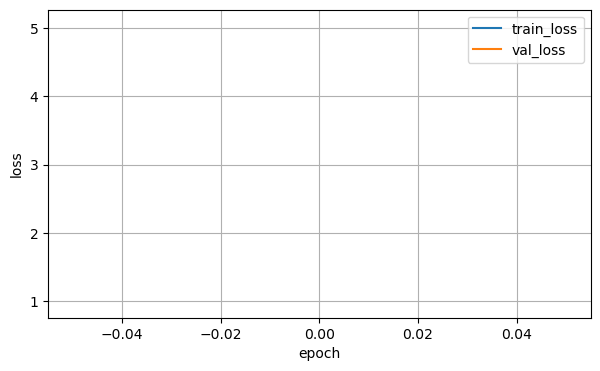

In [22]:
# Simple visualizations
plt.figure(figsize=(7,4))
if 'train_loss' in history and 'val_loss' in history:
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print('No loss history in trainer output')

Notes:
- This notebook follows the modular approach: it loads a merged config, builds dataloaders, models, and delegates training to `src.train.Trainer`.
- After you verify this notebook reproduces expected behaviour, delete or archive the old `legacy/scenario2_legacy.ipynb`.
- For reproducible CLI runs use: `python run_experiment.py --experiment scenario2 --config configs/scenario2.yaml --seed 42`.